# Plot XRD Patterns as a Heat Map sorted by relative Sn Composition

This notebook downloads all data and plots XRD heat maps. This notebook supports the publication:

An Inter-Laboratory Comparative High Throughput Experimental Study of Zn-Sn-Ti-O Thin Films

J. R. Hattrick-Simpers<sup>1</sup>, A. Zakutayev<sup>2</sup>, S. C. Barron<sup>1</sup>, Z. T. Trautt<sup>1</sup>, N. Nguyen<sup>1</sup>, K. Choudhary<sup>1</sup>, B. DeCost<sup>1</sup>, C. Phillips<sup>2</sup>, A. G. Kusne<sup>1</sup>, F. Yi<sup>1</sup>, A. Mehta<sup>3</sup>, I. Takeuchi<sup>4</sup>, J. D.Perkins<sup>2</sup>, M. L. Green<sup>1</sup>

1. National Institute of Standards and Technology (NIST), Gaithersburg, MD

1. National Renewable Energy Laboratory (NREL), Golden, CO

1. SLAC National Accelerator Laboratory, Menlo Park, CA

1. University of Maryland, College Park, MD

Contact: [htems@nist.gov](mailto:htems@nist.gov)

# Imports and Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
requests.packages.urllib3.disable_warnings()
import json
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skbeam.core.fitting.background import snip_method
from scipy import signal

In [2]:
def check_response(r,quiet=False):
    try:
        r_content = r.json(object_pairs_hook=OrderedDict)
    except:
        r_content = r.text
    if str(r.status_code)[0] is not "2":
        if not quiet: print("Error: ",r.status_code) 
        if not quiet: print(r.text)
    else:
        return r_content

In [3]:
def mdcs_query(host,query,format='json'):
    url = host.strip("/") + "/rest/explore/query-by-example"
    data = dict()
    data['query'] = query
    data['dataformat'] = format
    r = requests.post(url, data=data, verify=False) # This needs to be fixed
    return check_response(r)

# Get the data

In [4]:
host = "https://hte.registry.nist.gov/"

In [5]:
libraries = dict()

query = '{"content.project.identifier.id":"20.500.12048/proj.2015.1"}'
query_response = mdcs_query(host,query)
project = query_response[0]['content']['project']
library_registry = project['library']

for lib in library_registry:
    lib_id = lib['identifier']['id']
    query = '{"content.library.identifier.id":"'+lib_id+'"}'
    query_response = mdcs_query(host,query)
    library = query_response[0]['content']['library']
    libraries[lib_id] = library

In [6]:
samples = dict()

for lib_id,library in libraries.items():
    sample_registry = library['sample']
    
    for sample in sample_registry:
        sample_id = sample['identifier'][0]['id']
        samples[sample_id] = sample

In [7]:
xrd_patterns = dict()

for sample_id,sample in samples.items():
    dig_art_registry = sample['digital-artifact']
    for da in dig_art_registry:
        if 'xrd' in da['altName']:
            xrd_identifier = da['identifier']
            xrd_id = 0
            if isinstance(xrd_identifier,dict):
                xrd_id = xrd_identifier['id']
            if isinstance(xrd_identifier,list):
                xrd_id = xrd_identifier[0]['id']
            query = '{"content.library-xray-diffraction-measurement.identifier.id":"'+xrd_id+'"}'
            query_response = mdcs_query(host,query)
            xrd_pattern = query_response[0]['content']['library-xray-diffraction-measurement']
            xrd_patterns[xrd_id] = xrd_pattern

In [8]:
print(len(xrd_patterns))

618


# Munge Data

In [9]:
Sn_list= list()
lib_id_list = list()
xrd_id_list = list()

for sample_id,sample in samples.items():
    lib_id = sample['library']['identifier'][0]['id']
    dig_art_registry = sample['digital-artifact']
    xrd_id = None
    for da in dig_art_registry:
        if 'xrd' in da['altName']:
            xrd_identifier = da['identifier']
            if isinstance(xrd_identifier,dict):
                xrd_id = xrd_identifier['id']
            if isinstance(xrd_identifier,list):
                xrd_id = xrd_identifier[0]['id']
    constituent = sample['composition']['constituent']
    Sn_q = 0.0
    for c in constituent:
        if "Sn" in c['chemical-formula']:
            Sn_q = c['quantity']
    
    Sn_list.append(Sn_q)
    lib_id_list.append(lib_id)
    xrd_id_list.append(xrd_id)

In [10]:
Sn_xrd_df = pd.DataFrame()
Sn_xrd_df['Sn'] = Sn_list
Sn_xrd_df['lib'] = lib_id_list
Sn_xrd_df['xrd'] = xrd_id_list

# Plot Data

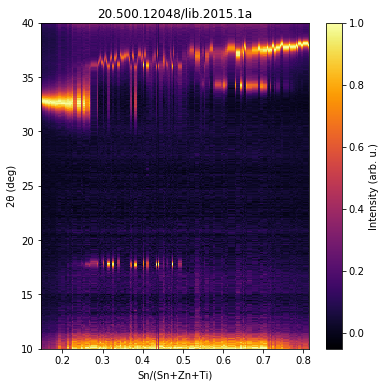

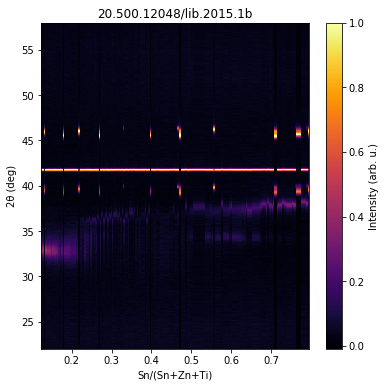

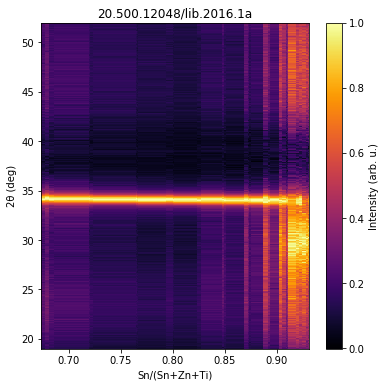

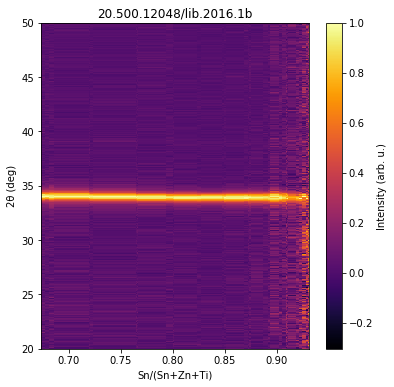

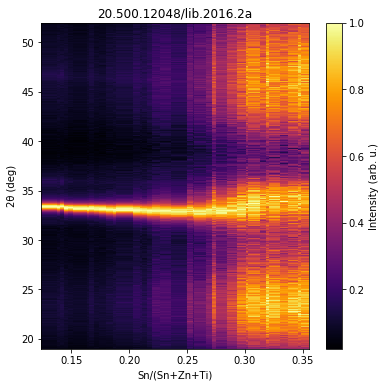

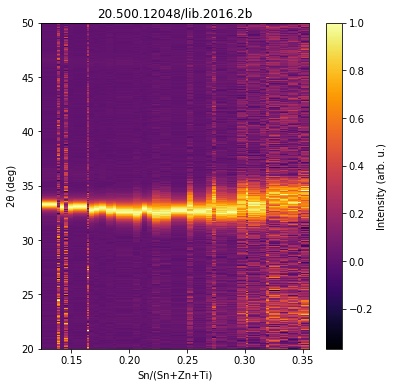

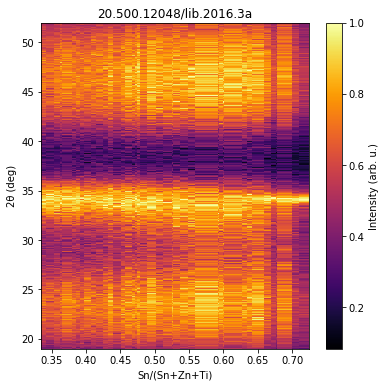

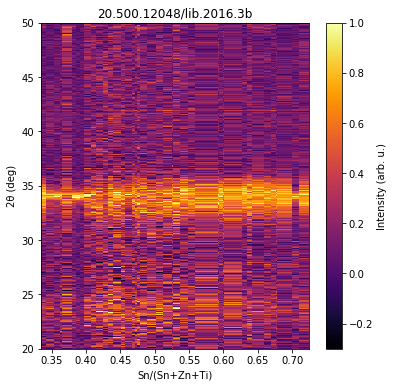

In [11]:
for lib_id,library in libraries.items():
    lib_df = Sn_xrd_df[Sn_xrd_df['lib']==lib_id].sort_values(by=['Sn'])

    lib_Sn_list = lib_df['Sn'].tolist()
    lib_xrd_list = lib_df['xrd'].tolist()
    lib_theta_list = xrd_patterns[lib_xrd_list[0]]['data']['angle-2-theta']['value']

    xrd_mat = list()
    for xrd in lib_xrd_list:
        pattern = np.array(xrd_patterns[xrd]['data']['intensity']['value'])
        bg = snip_method(pattern,0.0,1.0,0.0,iter_num=20)
        pattern_bg_sub = pattern - bg
        pattern_norm = pattern_bg_sub/max(pattern_bg_sub)
        xrd_mat.append(list(pattern_norm))
        

    xrd_mat_np = np.array(xrd_mat)
    xrd_mat_np_T = np.transpose(xrd_mat_np)

    X,Y = np.meshgrid(lib_Sn_list,lib_theta_list)
    Z = xrd_mat_np_T

    plt.figure(figsize=(6,6))
    plt.pcolormesh(X,Y,Z,cmap='inferno',linewidth=0,rasterized=True)
    plt.xlabel('Sn/(Sn+Zn+Ti)')
    plt.ylabel('2θ (deg)')
    cbar = plt.colorbar()
    cbar.set_label('Intensity (arb. u.)',rotation=90)
    plt.title(lib_id)
    f_name = 'xrd-Sn-'+lib_id.replace('20.500.12048/','')+'.pdf'
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()

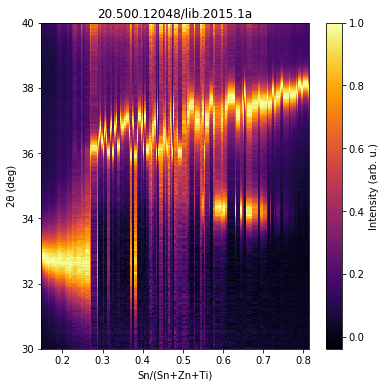

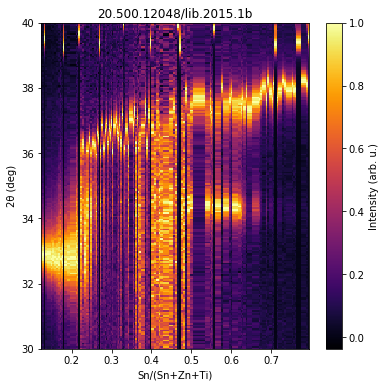

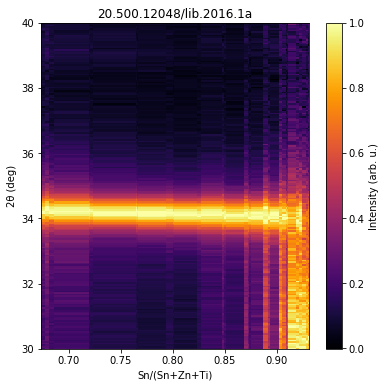

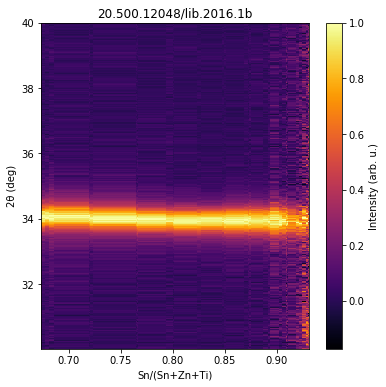

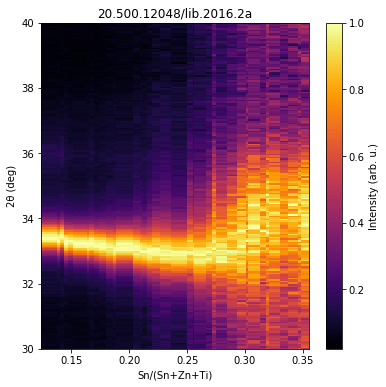

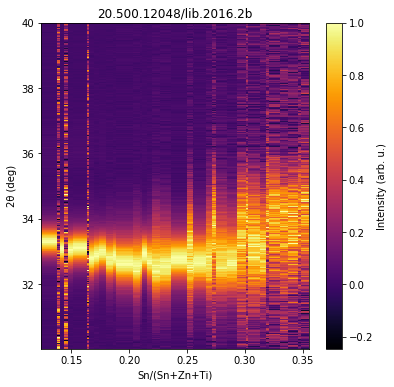

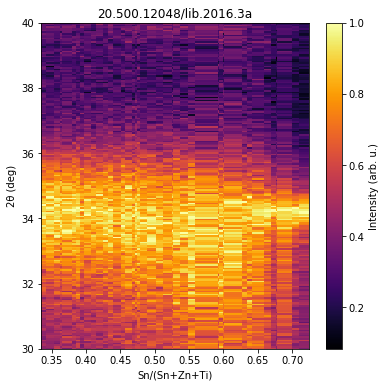

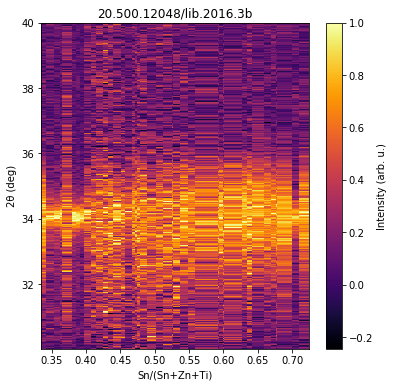

In [12]:
theta_min = 30.0
theta_max = 40.0

for lib_id,library in libraries.items():
    lib_df = Sn_xrd_df[Sn_xrd_df['lib']==lib_id].sort_values(by=['Sn'])

    lib_Sn_list = lib_df['Sn'].tolist()
    lib_xrd_list = lib_df['xrd'].tolist()
    lib_theta_list = xrd_patterns[lib_xrd_list[0]]['data']['angle-2-theta']['value']
    lib_theta_list_arr = np.array(lib_theta_list)
    condition = np.logical_and(lib_theta_list_arr >= theta_min, lib_theta_list_arr <= theta_max)
    lib_theta_list_new = lib_theta_list_arr[condition]
    lib_theta_list = list(lib_theta_list_new)

    xrd_mat = list()
    for xrd in lib_xrd_list:
        pattern = np.array(xrd_patterns[xrd]['data']['intensity']['value'])
        bg = snip_method(pattern,0.0,1.0,0.0,iter_num=20)
        pattern_bg_sub = pattern - bg
        pattern_range = pattern_bg_sub[condition]
        pattern_norm = pattern_range/max(pattern_range)
        xrd_mat.append(list(pattern_norm))
        

    xrd_mat_np = np.array(xrd_mat)
    xrd_mat_np_T = np.transpose(xrd_mat_np)

    X,Y = np.meshgrid(lib_Sn_list,lib_theta_list)
    Z = xrd_mat_np_T

    plt.figure(figsize=(6,6))
    plt.pcolormesh(X,Y,Z,cmap='inferno',linewidth=0,rasterized=True)
    plt.xlabel('Sn/(Sn+Zn+Ti)')
    plt.ylabel('2θ (deg)')
    cbar = plt.colorbar()
    cbar.set_label('Intensity (arb. u.)',rotation=90)
    plt.title(lib_id)
    f_name = 'xrd-Sn-range-'+lib_id.replace('20.500.12048/','')+'.pdf'
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()

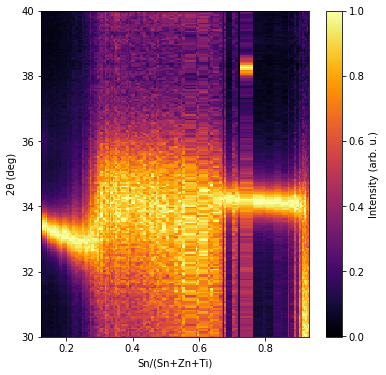

In [13]:
theta_min = 30.0
theta_max = 40.0

nrel_1 = "20.500.12048/lib.2016.1a"
nrel_2 = "20.500.12048/lib.2016.2a"
nrel_3 = "20.500.12048/lib.2016.3a"

stitch_condition = (Sn_xrd_df['lib']==nrel_1) | (Sn_xrd_df['lib']==nrel_2) | (Sn_xrd_df['lib']==nrel_3)
lib_df = Sn_xrd_df[stitch_condition].sort_values(by=['Sn'])

lib_Sn_list = lib_df['Sn'].tolist()
lib_xrd_list = lib_df['xrd'].tolist()
lib_theta_list = xrd_patterns[lib_xrd_list[0]]['data']['angle-2-theta']['value']
lib_theta_list_arr = np.array(lib_theta_list)
condition = np.logical_and(lib_theta_list_arr >= theta_min, lib_theta_list_arr <= theta_max)
lib_theta_list_new = lib_theta_list_arr[condition]
lib_theta_list = list(lib_theta_list_new)

xrd_mat = list()
for xrd in lib_xrd_list:
    pattern = np.array(xrd_patterns[xrd]['data']['intensity']['value'])
    bg = snip_method(pattern,0.0,1.0,0.0,iter_num=20)
    pattern_bg_sub = pattern - bg
    pattern_range = pattern_bg_sub[condition]
    pattern_norm = pattern_range/max(pattern_range)
    xrd_mat.append(list(pattern_norm))


xrd_mat_np = np.array(xrd_mat)
xrd_mat_np_T = np.transpose(xrd_mat_np)

X,Y = np.meshgrid(lib_Sn_list,lib_theta_list)
Z = xrd_mat_np_T

plt.figure(figsize=(6,6))
plt.pcolormesh(X,Y,Z,cmap='inferno',linewidth=0,rasterized=True)
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('2θ (deg)')
cbar = plt.colorbar()
cbar.set_label('Intensity (arb. u.)',rotation=90)
f_name = 'xrd-Sn-range-NREL-NREL.pdf'
plt.savefig(f_name, bbox_inches='tight')
plt.show()

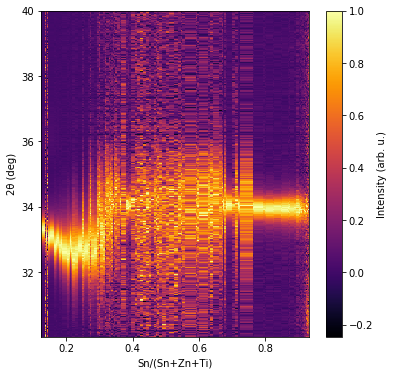

In [14]:
theta_min = 30.0
theta_max = 40.0

nrel_1 = "20.500.12048/lib.2016.1b"
nrel_2 = "20.500.12048/lib.2016.2b"
nrel_3 = "20.500.12048/lib.2016.3b"

stitch_condition = (Sn_xrd_df['lib']==nrel_1) | (Sn_xrd_df['lib']==nrel_2) | (Sn_xrd_df['lib']==nrel_3)
lib_df = Sn_xrd_df[stitch_condition].sort_values(by=['Sn'])

lib_Sn_list = lib_df['Sn'].tolist()
lib_xrd_list = lib_df['xrd'].tolist()
lib_theta_list = xrd_patterns[lib_xrd_list[0]]['data']['angle-2-theta']['value']
lib_theta_list_arr = np.array(lib_theta_list)
condition = np.logical_and(lib_theta_list_arr >= theta_min, lib_theta_list_arr <= theta_max)
lib_theta_list_new = lib_theta_list_arr[condition]
lib_theta_list = list(lib_theta_list_new)

xrd_mat = list()
for xrd in lib_xrd_list:
    pattern = np.array(xrd_patterns[xrd]['data']['intensity']['value'])
    bg = snip_method(pattern,0.0,1.0,0.0,iter_num=20)
    pattern_bg_sub = pattern - bg
    pattern_range = pattern_bg_sub[condition]
    pattern_norm = pattern_range/max(pattern_range)
    xrd_mat.append(list(pattern_norm))


xrd_mat_np = np.array(xrd_mat)
xrd_mat_np_T = np.transpose(xrd_mat_np)

X,Y = np.meshgrid(lib_Sn_list,lib_theta_list)
Z = xrd_mat_np_T

plt.figure(figsize=(6,6))
plt.pcolormesh(X,Y,Z,cmap='inferno',linewidth=0,rasterized=True)
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('2θ (deg)')
cbar = plt.colorbar()
cbar.set_label('Intensity (arb. u.)',rotation=90)
f_name = 'xrd-Sn-range-NREL-NIST.pdf'
plt.savefig(f_name, bbox_inches='tight')
plt.show()